# Meta-Labeling Experiments: A Step-by-Step Guide

## Introduction

This notebook recreates the meta-labeling experiments from Hudson & Thames' research in a beginner-friendly manner. Meta-labeling is a machine learning technique that sits on top of a primary trading strategy to improve performance by filtering out false positive signals.

**Key Concepts:**
- **Primary Model**: Generates trading signals (buy/sell/hold)
- **Triple Barrier Method**: Advanced labeling technique that accounts for stop-loss, take-profit, and time-based exits
- **Meta-Labeling**: Secondary ML model that decides whether to act on primary model signals
- **Goal**: Improve Sharpe ratio, reduce drawdown, and increase precision

## Setup and Dependencies

In [1]:
# --- Extension Setup ---
%load_ext autoreload
%load_ext line_profiler
%autoreload 3 -p

# --- Module Imports ---
import sys
sys.path.append("..")  # Adjust if your afml repo is nested differently

# --- Autoreload Target ---
%aimport afml

# --- AFML Initialization ---
import afml

# Check if auto-reload is available
print(f"Auto-reload available: {afml.AUTO_RELOAD_AVAILABLE}")

# Setup with auto-reload enabled
app = afml.setup_jupyter(enable_auto_reload=True)

# # --- Logging (Optional but Recommended) ---
# from loguru import logger
# from pathlib import Path

# # Optional: clear old logs
# log_path = Path("logs") / "afml_session.log"
# log_path.parent.mkdir(exist_ok=True)
# log_path.unlink(missing_ok=True)

# # Configure Loguru
# logger.add(log_path, level="INFO", rotation="10 MB", retention="10 days")
# logger.info("Session started")

# --- Environment Diagnostics ---
from pathlib import Path
print(f"Working Dir: {Path.cwd()}")


2025-10-30 19:02:59.678 | DEBUG    | afml.cache:<module>:344 - Auto-reload functionality available
2025-10-30 19:03:00.667 | DEBUG    | afml.cache:_configure_numba:61 - Numba cache configured: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-10-30 19:03:00.669 | INFO     | afml.cache:initialize_cache_system:310 - AFML cache system initialized:
2025-10-30 19:03:00.671 | INFO     | afml.cache:initialize_cache_system:311 -   Joblib cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
2025-10-30 19:03:00.674 | INFO     | afml.cache:initialize_cache_system:312 -   Numba cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-10-30 19:03:00.676 | INFO     | afml.cache:initialize_cache_system:318 -   Loaded stats: 4 functions, 37.8% hit rate
2025-10-30 19:03:07.124 | DEBUG    | afml.cache.selective_cleaner:_load_tracking_data:39 - Loaded tracking data for 17 functions
2025-10-30 19:03:17.163 | DEBUG    | afml:<module>:106 - Imported lightweight modules direc

Auto-reload available: True
Working Dir: c:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\notebooks


In [2]:
import warnings
import winsound
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import MetaTrader5 as mt5
from sklearn.base import clone
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
)
from sklearn.tree import DecisionTreeClassifier

from afml.cache import cache_maintenance
from afml.cross_validation import (
    PurgedKFold,
    PurgedSplit,
    analyze_cross_val_scores,
    ml_cross_val_score,
    probability_weighted_accuracy,
)
from afml.data_structures.bars import *
from afml.labeling.triple_barrier import (
    add_vertical_barrier,
    get_event_weights,
    triple_barrier_labels,
)
from afml.mt5.load_data import get_bars, login_mt5
from afml.sample_weights.optimized_attribution import (
    get_weights_by_time_decay_optimized,
)
# from afml.sampling import get_ind_mat_average_uniqueness, get_ind_matrix, seq_bootstrap
from afml.strategies import (
    BollingerStrategy,
    MACrossoverStrategy,
    create_bollinger_features,
    get_entries,
)
from afml.util import get_daily_vol, value_counts_data

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
# plt.style.use("dark_background")from afml.util import get_daily_vol, value_counts_data

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
# plt.style.use("dark_background")

## 1. Data Preparation

In [3]:
symbol = "EURUSD"
start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2023-12-31"        

## 2. Bollinger Band Strategy

In [4]:
bb_timeframe = "M5"
file = Path(r"..\data\EURUSD_M5_time_2018-01-01-2024-12-31.parq")
bb_time_bars = pd.read_parquet(file)

In [5]:
bb_period, bb_std = 20, 2 # Bollinger Band parameters
bb_strategy = BollingerStrategy(window=bb_period, num_std=bb_std)
bb_lookback = 10
bb_pt_barrier, bb_sl_barrier, bb_time_horizon = (1, 2, dict(days=1))
min_ret = 5e-5
bb_vol_multiplier = 1

### Time-Bars

In [6]:
bb_side = bb_strategy.generate_signals(bb_time_bars)
bb_df = bb_time_bars.loc[sample_start : sample_end]

print(f"{bb_strategy.get_strategy_name()} Signals:")
value_counts_data(bb_side.reindex(bb_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = 100
vol_target = get_daily_vol(bb_df.close, vol_lookback) * bb_vol_multiplier
close = bb_df.close
_, t_events = get_entries(bb_strategy, bb_df, filter_threshold=vol_target)

vertical_barriers = add_vertical_barrier(t_events, close, **bb_time_horizon)

Bollinger_w20_std2 Signals:

        count  proportion
side                     
 0    373,536    0.842213
-1     35,095    0.079129
 1     34,886    0.078658



2025-10-30 19:03:22.590 | INFO     | afml.filters.filters:cusum_filter:151 - 19,458 CUSUM-filtered events
2025-10-30 19:03:22.675 | INFO     | afml.strategies.signal_processing:get_entries:105 - Bollinger_w20_std2 | 10,384 (14.84%) trade events selected by CUSUM filter using series.


#### Feature Engineering

In [7]:
bb_feat = create_bollinger_features(bb_time_bars, bb_period, bb_std)
bb_feat_time = bb_feat.join(bb_side, how="inner")
bb_feat_time.info()
# not_stationary = is_stationary(bb_feat_time)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 516825 entries, 2018-01-02 23:20:00 to 2024-12-31 00:00:00
Data columns (total 49 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   spread               516825 non-null  float32
 1   vol                  516825 non-null  float32
 2   h1_vol               516825 non-null  float32
 3   h4_vol               516825 non-null  float32
 4   d1_vol               516825 non-null  float32
 5   ret                  516825 non-null  float32
 6   ret_5                516825 non-null  float32
 7   ret_10               516825 non-null  float32
 8   ret_1_lag_1          516825 non-null  float32
 9   ret_5_lag_1          516825 non-null  float32
 10  ret_10_lag_1         516825 non-null  float32
 11  ret_1_lag_2          516825 non-null  float32
 12  ret_5_lag_2          516825 non-null  float32
 13  ret_10_lag_2         516825 non-null  float32
 14  ret_1_lag_3          516825 non-nu

#### Triple-Barrier Method

In [8]:
bb_events_tb = triple_barrier_labels(
    close,
    vol_target,
    t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    vertical_barrier_zero=True,
    verbose=False,
)

bb_events_tb_time = bb_events_tb.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tb.bin, verbose=True)

weights = get_event_weights(bb_events_tb, close)
av_uniqueness = weights['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1, sl=2, h={'days': 1}):

     count  proportion
bin                   
-1   5,109    0.505741
 1   4,993    0.494259

Average Uniqueness: 0.7465


In [9]:
bb_events_tb = triple_barrier_labels(
    close,
    vol_target,
    t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side,
    vertical_barrier_zero=True,
    verbose=False,
)

bb_events_tb_time_meta = bb_events_tb.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tb.bin, verbose=True)

weights = get_event_weights(bb_events_tb, close)
av_uniqueness = weights['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1, sl=2, h={'days': 1}):

     count  proportion
bin                   
1    6,506    0.626601
0    3,877    0.373399

Average Uniqueness: 0.5488


#### Cross-Validation of Weighting Methods

In [10]:
from os import cpu_count

N_JOBS = cpu_count() - 1
N_ESTIMATORS = 100

##### Primary Model 

In [ ]:
cont = bb_events_tb_time.copy()
X = bb_feat_time.reindex(cont.index)
y = cont["bin"]
t1 = cont["t1"]

test_size = 0.2

train, test = PurgedSplit(t1, test_size).split(X)
X_train, X_test, y_train, y_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
    )

cont_train = get_event_weights(cont.iloc[train], bb_df.close)
bb_cont_train = cont_train.copy()

n_splits = 10
pct_embargo = 0.01
cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)

In [ ]:
avg_u = cont_train.tW.mean()
print(f"Average Uniqueness in Training Set: {avg_u:.4f}")
weighting_schemes = {
    "unweighted": pd.Series(1., index=cont_train.index),
    "uniqueness": cont_train["tW"],
    "return": cont_train["w"],
    }

decay_factors = [0.1, 0.25, 0.5, 0.75, 0.9]
time_decay_weights = {}
for time_decay in decay_factors:
    for linear in (1, 0):
        decay_w = get_weights_by_time_decay_optimized(
                    triple_barrier_events=cont,
                    close_index=close.index,
                    last_weight=time_decay,
                    linear=linear,
                    av_uniqueness=cont_train["tW"],
                )
        method = "linear" if linear else "exp"
        time_decay_weights[f"{method}_time_decay_{time_decay}"] = decay_w
        
# for k, v in time_decay_weights.items():
#     weighting_schemes[k] = v

weighting_schemes.keys()

Average Uniqueness in Training Set: 0.7473


dict_keys(['unweighted', 'uniqueness', 'return'])

In [ ]:
random_state = 42
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=N_ESTIMATORS,
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=N_JOBS,  # Use all available cores
    )

clf0 = rf
clf1 = clone(rf).set_params(class_weight='balanced_subsample')
clf2 = clone(rf).set_params(max_samples=avg_u)
clf3 = clone(rf).set_params(max_samples=avg_u, class_weight='balanced_subsample')

clfs = {k: v for k, v in zip(['standard', 'balanced_subsample', 'max_samples', 'combined'], [clf0, clf1, clf2, clf3])}
clfs

{'standard': RandomForestClassifier(criterion='entropy', min_weight_fraction_leaf=0.05,
                        n_estimators=500, n_jobs=3, random_state=42),
 'balanced_subsample': RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                        min_weight_fraction_leaf=0.05, n_estimators=500,
                        n_jobs=3, random_state=42),
 'max_samples': RandomForestClassifier(criterion='entropy', max_samples=0.7472647467858778,
                        min_weight_fraction_leaf=0.05, n_estimators=500,
                        n_jobs=3, random_state=42),
 'combined': RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                        max_samples=0.7472647467858778,
                        min_weight_fraction_leaf=0.05, n_estimators=500,
                        n_jobs=3, random_state=42)}

In [ ]:
# cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)
# cv_scores_d = {k: {} for k in clfs.keys()}
# print(rf.__class__.__name__, "Weighting Schemes")
# all_clf_scores_df = pd.DataFrame(dtype=pd.StringDtype())
# best_models = []

# for scheme, sample_weights in weighting_schemes.items():
#     best_score, best_model = None, None
#     for param, clf in clfs.items():
#         w = sample_weights.values
#         cv_scores = ml_cross_val_score(
#             clf, X_train, y_train, cv_gen, 
#             sample_weight_train=w, 
#             sample_weight_score=w,
#             scoring="log_loss",
#         )
#         score = cv_scores.mean()
#         cv_scores_d[param][scheme] = score
#         best_score = max(best_score, score) if best_score is not None else score
#         if score == best_score:
#             best_model = param
#         all_clf_scores_df.loc[param, scheme] = f"{cv_scores.mean():.6f} ± {cv_scores.std():.4f}"
#     best_models.append(best_model)
#     print(f"{scheme} {best_model} model achieved the best neg_log_loss score of {best_score:.6f}.")

# print()
# pprint(all_clf_scores_df, sort_dicts=False)
# best_model = max(best_models, key=best_models.count)
# best_clf = clone(clfs[best_model])
# print(f"\nSelected Best Classifier ({best_model}): {best_clf}")

In [ ]:
from afml.cross_validation.cross_validation import analyze_cross_val_scores

all_cv_scores_d = {}
all_cms = {}
best_score, best_model = None, None
all_cv_scores_df = pd.DataFrame(dtype=pd.StringDtype())
scoring = 'f1' if set(y_train.unique()) == {0, 1} else 'neg_log_loss'
best_clf = clfs['balanced_subsample']

for scheme, sample_weights in weighting_schemes.items():
    w = sample_weights.values
    cv_scores, cv_scores_df, cms = analyze_cross_val_scores(
        best_clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    score = cv_scores[scoring].mean()
    all_cv_scores_d[scheme] = cv_scores
    all_cms[scheme] = cms
    best_score = max(best_score, score) if best_score is not None else score
    if score == best_score:
        best_model = scheme
    for idx, row in cv_scores_df.iterrows():
        all_cv_scores_df.loc[idx, scheme] = f"{row['mean']:.4f} ± {row['std']:.3f}"
pprint(all_cv_scores_df)
print(f"\n{best_model} model achieved the best {scoring} score of {best_score:.6f}\n")

                   unweighted       uniqueness           return
accuracy       0.5059 ± 0.019   0.5052 ± 0.018   0.6206 ± 0.019
pwa            0.5110 ± 0.024   0.5117 ± 0.024   0.6312 ± 0.018
neg_log_loss  -0.6934 ± 0.002  -0.6934 ± 0.002  -0.6624 ± 0.007
precision      0.4966 ± 0.026   0.4950 ± 0.023   0.6105 ± 0.032
recall         0.5042 ± 0.053   0.5109 ± 0.049   0.6041 ± 0.042
f1             0.4983 ± 0.025   0.5009 ± 0.021   0.6071 ± 0.035

return model achieved the best neg_log_loss score of -0.662436.



In [ ]:
pprint(all_cms, sort_dicts=False)

{'unweighted': [{'fold': 1, 'TN': 230.0, 'FP': 193.0, 'FN': 204.0, 'TP': 182.0},
                {'fold': 2, 'TN': 209.0, 'FP': 197.0, 'FN': 221.0, 'TP': 182.0},
                {'fold': 3, 'TN': 183.0, 'FP': 249.0, 'FN': 149.0, 'TP': 227.0},
                {'fold': 4, 'TN': 183.0, 'FP': 223.0, 'FN': 186.0, 'TP': 216.0},
                {'fold': 5, 'TN': 229.0, 'FP': 210.0, 'FN': 153.0, 'TP': 216.0},
                {'fold': 6, 'TN': 218.0, 'FP': 159.0, 'FN': 236.0, 'TP': 195.0},
                {'fold': 7, 'TN': 207.0, 'FP': 178.0, 'FN': 229.0, 'TP': 194.0},
                {'fold': 8, 'TN': 237.0, 'FP': 190.0, 'FN': 205.0, 'TP': 176.0},
                {'fold': 9, 'TN': 190.0, 'FP': 236.0, 'FN': 185.0, 'TP': 197.0},
                {'fold': 10,
                 'TN': 215.0,
                 'FP': 190.0,
                 'FN': 200.0,
                 'TP': 203.0}],
 'uniqueness': [{'fold': 1,
                 'TN': 165.33,
                 'FP': 149.69,
                 'FN': 142.03,

##### Meta-Labelled

In [11]:
cont = bb_events_tb_time_meta.copy()
X = bb_feat_time.reindex(cont.index)
y = cont["bin"]
t1 = cont["t1"]

test_size = 0.2

train, test = PurgedSplit(t1, test_size).split(X)
X_train, X_test, y_train, y_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
    )

cont_train = get_event_weights(cont.iloc[train], bb_df.close)
bb_cont_train_meta = cont_train.copy()

n_splits = 10
pct_embargo = 0.01
cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)

In [12]:
avg_u = cont_train.tW.mean()
weighting_schemes = {
    "unweighted": pd.Series(1., index=cont_train.index),
    "uniqueness": cont_train["tW"],
    "return": cont_train["w"],
    }

decay_factors = [0.1, 0.25, 0.5, 0.75, 0.9]
time_decay_weights = {}
for time_decay in decay_factors:
    for linear in (1, 0):
        decay_w = get_weights_by_time_decay_optimized(
                    triple_barrier_events=cont,
                    close_index=close.index,
                    last_weight=time_decay,
                    linear=linear,
                    av_uniqueness=cont_train["tW"],
                )
        method = "linear" if linear else "exp"
        time_decay_weights[f"{method}_time_decay_{time_decay}"] = decay_w
        
# for k, v in time_decay_weights.items():
#     weighting_schemes[k] = v

weighting_schemes.keys()

dict_keys(['unweighted', 'uniqueness', 'return'])

In [13]:
random_state = 42
min_w_leaf = 0.05
print(f"Average uniqueness: {avg_u:.4f}\n")
rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=N_ESTIMATORS,
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    max_depth=6,
    n_jobs=N_JOBS,  # Use all available cores
    )

clf0 = rf
clf1 = clone(rf).set_params(class_weight='balanced_subsample')
clf2 = clone(rf).set_params(max_samples=avg_u)
clf3 = clone(rf).set_params(max_samples=avg_u, class_weight='balanced_subsample')
clfs = {k: v for k, v in zip(['standard', 'balanced_subsample', 'max_samples', 'combined'], [clf0, clf1, clf2, clf3])}

Average uniqueness: 0.5473



In [22]:
# cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)
# cv_scores_d = {k: {} for k in clfs.keys()}
# print(rf.__class__.__name__, "Weighting Schemes")
# all_clf_scores_df = pd.DataFrame(dtype=pd.StringDtype())
# best_models = []

# for scheme, sample_weights in weighting_schemes.items():
#     best_score, best_model = None, None
#     for param, clf in clfs.items():
#         w = sample_weights.values
#         cv_scores = ml_cross_val_score(
#             clf, X_train, y_train, cv_gen, 
#             sample_weight_train=w, 
#             sample_weight_score=w,
#             scoring="f1",
#         )
#         score = cv_scores.mean()
#         cv_scores_d[param][scheme] = score
#         best_score = max(best_score, score) if best_score is not None else score
#         if score == best_score:
#             best_model = param
#         all_clf_scores_df.loc[param, scheme] = f"{cv_scores.mean():.6f} ± {cv_scores.std():.4f}"
#     best_models.append(best_model)
#     print(f"{scheme} {best_model} model achieved the best f1 score of {best_score:.6f}")

# print()
# pprint(all_clf_scores_df, sort_dicts=False)
# best_model = max(best_models, key=best_models.count)
# best_clf = clone(clfs[best_model])
# print(f"\nSelected Best Classifier ({best_model}): {best_clf}")

In [ ]:
all_cv_scores_d = {}
all_cms = {}
best_score, best_model = None, None
all_cv_scores_df = pd.DataFrame(dtype=pd.StringDtype())
best_clf = clfs["max_samples"]
scoring = 'f1' if set(y_train.unique()) == {0, 1} else 'neg_log_loss'

for scheme, sample_weights in weighting_schemes.items():
    w = sample_weights.values
    cv_scores, cv_scores_df, cms = analyze_cross_val_scores(
        best_clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    score = cv_scores[scoring].mean()
    all_cv_scores_d[scheme] = cv_scores
    all_cms[scheme] = cms
    best_score = max(best_score, score) if best_score is not None else score
    if score == best_score:
        best_model = scheme
    for idx, row in cv_scores_df.iterrows():
        all_cv_scores_df.loc[idx, scheme] = f"{row['mean']:.4f} ± {row['std']:.3f}"
pprint(all_cv_scores_df)
print(f"\n{best_model} model achieved the best {scoring} score of {best_score:.6f}\n")

                   unweighted       uniqueness           return
accuracy       0.6262 ± 0.022   0.6175 ± 0.024   0.6228 ± 0.022
pwa            0.6309 ± 0.027   0.6251 ± 0.031   0.6317 ± 0.019
neg_log_loss  -0.6604 ± 0.015  -0.6641 ± 0.016  -0.6611 ± 0.008
precision      0.6262 ± 0.022   0.6176 ± 0.024   0.0000 ± 0.000
recall         1.0000 ± 0.000   0.9998 ± 0.001   0.0000 ± 0.000
f1             0.7699 ± 0.016   0.7632 ± 0.019   0.0000 ± 0.000

unweighted model achieved the best f1 score of 0.769903



In [24]:
pprint(all_cms, sort_dicts=False)

{'unweighted': [{'fold': 1, 'TN': 0.0, 'FP': 313.0, 'FN': 0.0, 'TP': 518.0},
                {'fold': 2, 'TN': 0.0, 'FP': 328.0, 'FN': 0.0, 'TP': 503.0},
                {'fold': 3, 'TN': 0.0, 'FP': 271.0, 'FN': 0.0, 'TP': 560.0},
                {'fold': 4, 'TN': 0.0, 'FP': 300.0, 'FN': 0.0, 'TP': 531.0},
                {'fold': 5, 'TN': 0.0, 'FP': 304.0, 'FN': 0.0, 'TP': 527.0},
                {'fold': 6, 'TN': 0.0, 'FP': 327.0, 'FN': 0.0, 'TP': 504.0},
                {'fold': 7, 'TN': 0.0, 'FP': 335.0, 'FN': 0.0, 'TP': 495.0},
                {'fold': 8, 'TN': 0.0, 'FP': 306.0, 'FN': 0.0, 'TP': 524.0},
                {'fold': 9, 'TN': 0.0, 'FP': 299.0, 'FN': 0.0, 'TP': 531.0},
                {'fold': 10, 'TN': 0.0, 'FP': 322.0, 'FN': 0.0, 'TP': 508.0}],
 'uniqueness': [{'fold': 1, 'TN': 0.0, 'FP': 179.9, 'FN': 0.0, 'TP': 295.4},
                {'fold': 2, 'TN': 0.0, 'FP': 181.38, 'FN': 0.0, 'TP': 260.87},
                {'fold': 3, 'TN': 0.0, 'FP': 148.29, 'FN': 0.0, 'TP': 29

#### Sequential Bootstrap

##### Data Prep

In [101]:
t = slice(0, None)
idx = y_train.index[t]
t1_train = cont_train.loc[idx, 't1']
w_train = cont_train.loc[idx, "tW"]
cv_gen = PurgedKFold(n_splits, t1=t1_train, pct_embargo=0.01)
price_bars_index = bb_df.index[
    (bb_df.index >= t1_train.index.min()) & (bb_df.index <= t1_train.max())
    ]

##### Classifier Initializion

In [107]:
from sklearn.tree import DecisionTreeClassifier
from afml.cross_validation.scoring import probability_weighted_accuracy
from afml.ensemble.sb_bagging import (
    SequentiallyBootstrappedBaggingClassifier,
    compute_custom_oob_metrics,
)

n_splits = 5
min_w_leaf = 0.05
max_depth = 6
min_samples_split = 20
min_samples_leaf = 10
n_estimators = 100
random_state = 7

# More straightforward and gives you better control
base_tree = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    
    # Pre-pruning parameters
    min_weight_fraction_leaf=min_w_leaf,
    max_depth=max_depth,
    # min_samples_split=min_samples_split,
    # min_samples_leaf=min_samples_leaf,
    max_features='sqrt',
)
base_rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1,
    bootstrap=False,
    class_weight='balanced_subsample',
    min_weight_fraction_leaf=min_w_leaf,
    max_depth=max_depth,
    # min_samples_split=min_samples_split,
    # min_samples_leaf=min_samples_leaf,
    )
rf = RandomForestClassifier(
    criterion='entropy',
    class_weight='balanced_subsample',
    n_estimators=n_estimators,
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    max_depth=max_depth,
    # min_samples_split=min_samples_split,
    # min_samples_leaf=min_samples_leaf,
    max_samples=avg_u,
    oob_score=True,
    n_jobs=N_JOBS,  # Use all available cores
    )
bagged_rf = BaggingClassifier(
    estimator=base_rf,
    n_estimators=n_estimators,
    max_samples=avg_u,
    oob_score=True,
    n_jobs=N_JOBS,
    )
bagged_tree = BaggingClassifier(
    estimator=base_tree,
    n_estimators=n_estimators,
    max_samples=avg_u,
    oob_score=True,
    n_jobs=N_JOBS,
    )

In [119]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier


gboost = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        min_weight_fraction_leaf=min_w_leaf,
        max_features='sqrt',
    )
adaboost = AdaBoostClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
    )
adaboost.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=w_train.values,
)
gboost.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=w_train.values,
)


KeyError: 'f1'

In [ ]:
seq_rf = SequentiallyBootstrappedBaggingClassifier(
    samples_info_sets=t1_train,
    price_bars_index=price_bars_index,
    estimator=base_rf,
    n_estimators=n_estimators,
    max_features=1,
    oob_score=True,
    max_samples=avg_u,
    n_jobs=N_JOBS,
    random_state=random_state,
    verbose=0,
)
seq_rf

SequentiallyBootstrappedBaggingClassifier(estimator=RandomForestClassifier(bootstrap=False,
                                                                           class_weight='balanced_subsample',
                                                                           criterion='entropy',
                                                                           max_depth=6,
                                                                           min_weight_fraction_leaf=0.05,
                                                                           n_estimators=1),
                                          max_features=1,
                                          max_samples=0.5473256253464687,
                                          n_estimators=100, n_jobs=3,
                                          oob_score=True,
                                          price_bars_index=DatetimeIndex(['2018-01-03 00:10:00', '2018-0...
2018-01-03 01:30:00   2018-01-03 01:50:00
2018-01-03 02:40:00   2018-01-03 06:45:00
2018-01-03 05:35:00   2018-01-03 08:10:00
2018-01-03 06:45:00   2018-01-03 07:55:00
                              ...        
2022-10-04 07:55:00   2022-10-04 09:10:00
2022-10-04 08:25:00   2022-10-04 12:30:00
2022-10-04 09:20:00   2022-10-04 11:10:00
2022-10-04 11:10:00   2022-10-04 12:10:00
2022-10-04 12:25:00   2022-10-04 17:15:00
Name: t1, Length: 8306, dtype: datetime64[ns])

##### Tests

In [ ]:
bagged_tree = bagged_tree.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=w_train.values,
)
print(f"Bagged Decision Tree OOB Score: {bagged_tree.oob_score_:.4f}")

rf = rf.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=w_train.values,
)
print(f"RF OOB Score: {rf.oob_score_:.4f}")

bagged_rf = bagged_rf.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    sample_weight=w_train.values,
)
print(f"Bagged RF OOB Score: {bagged_rf.oob_score_:.4f}")

Bagged Decision Tree OOB Score: 0.523959
RF OOB Score: 0.516976
Bagged RF OOB Score: 0.527932


In [111]:
seq_rf.fit(
    X_train.loc[idx],
    y_train.loc[idx],
    # sample_weight=w_train.values,
)
print(f"Sequential Bootstrap OOB Score: {seq_rf.oob_score_:.4f}")

Sequential Bootstrap OOB Score: 0.522153


In [ ]:
ensembles = {
    "standard_rf": {"classifier": rf, 
                 "pred": rf.predict(X_test),
                 "prob": rf.predict_proba(X_test),
                 "oob": rf.oob_score_,
                },
    "bagged_rf": {"classifier": bagged_rf, 
                 "pred": bagged_rf.predict(X_test),
                 "prob": bagged_rf.predict_proba(X_test),
                 "oob": bagged_rf.oob_score_,
                },
    "bagged_tree": {"classifier": bagged_tree, 
                 "pred": bagged_tree.predict(X_test),
                 "prob": bagged_tree.predict_proba(X_test),
                 "oob": bagged_tree.oob_score_,
                },
    "sequential_rf": {"classifier": seq_rf, 
                   "pred": seq_rf.predict(X_test),
                   "prob": seq_rf.predict_proba(X_test),
                   "oob": seq_rf.oob_score_,
                   },
}

scoring_methods = {
            "accuracy": accuracy_score,
            "pwa": probability_weighted_accuracy,
            "neg_log_loss": log_loss,
            "precision": precision_score,
            "recall": recall_score,
            "f1": f1_score,
        }
rf_seq_scores = pd.DataFrame()

for clf in ensembles.keys():
    for method, scoring in scoring_methods.items():
        if scoring in (probability_weighted_accuracy, log_loss):
            y_pred = ensembles[clf]["prob"]
        else:
            y_pred = ensembles[clf]["pred"]
        score = scoring(y_test, y_pred)
        if method == "neg_log_loss":
            score *= -1
        rf_seq_scores.loc[method, clf] = score
    rf_seq_scores.loc["oob", clf] = ensembles[clf]["oob"]
    rf_seq_scores.loc["oob_test_gap", clf] = ensembles[clf]["oob"] - rf_seq_scores.loc["accuracy", clf]

rf_seq_scores.round(4)

,standard_rf,bagged_rf,bagged_tree,sequential_tree,sequential_rf
accuracy,0.5058,0.5154,0.5039,0.5197,0.5197
pwa,0.4935,0.4994,0.4971,0.5237,0.5237
neg_log_loss,-0.6967,-0.6960,-0.6964,-0.6927,-0.6927
precision,0.6508,0.6521,0.6431,0.6339,0.6339
recall,0.4613,0.4912,0.4736,0.5586,0.5586
f1,0.5399,0.5603,0.5455,0.5939,0.5939
oob,0.5170,0.5279,0.5240,0.5222,0.5222
oob_test_gap,0.0112,0.0125,0.0201,0.0024,0.0024


In [113]:
all_cv_scores = pd.DataFrame()
all_cv_scores_std = pd.DataFrame(dtype=pd.StringDtype())
all_cms = []

for name in ensembles.keys():
    clf = ensembles[name]["classifier"]
    w = cont_train['tW'].values
    if isinstance(clf, SequentiallyBootstrappedBaggingClassifier):
        w = None
        pprint(all_cv_scores)
    cv_scores, cv_scores_df, cms = analyze_cross_val_scores(
        clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    all_cms.append(cms)
    for idx, row in cv_scores_df.iterrows():
        all_cv_scores.loc[idx, name] = row['mean']
        all_cv_scores_std.loc[idx, name] = f"{row['mean']:.3f} ± {row['std']:.3f}"
    print(name, "done.")
    
all_cv_scores.round(4)

standard_rf done.
bagged_rf done.
bagged_tree done.
              standard_rf  bagged_rf  bagged_tree
accuracy         0.508558   0.514071     0.511493
pwa              0.512590   0.518497     0.518167
neg_log_loss    -0.695432  -0.694601    -0.694581
precision        0.636594   0.638469     0.637870
recall           0.475764   0.489321     0.482706
f1               0.538983   0.547638     0.543429
sequential_tree done.
              standard_rf  bagged_rf  bagged_tree  sequential_tree
accuracy         0.508558   0.514071     0.511493         0.526609
pwa              0.512590   0.518497     0.518167         0.543853
neg_log_loss    -0.695432  -0.694601    -0.694581        -0.691993
precision        0.636594   0.638469     0.637870         0.637163
recall           0.475764   0.489321     0.482706         0.566962
f1               0.538983   0.547638     0.543429         0.599180


KeyboardInterrupt: 

In [121]:
for name, clf in zip(['gboost', 'adaboost'], [gboost, adaboost]):
    cv_scores, cv_scores_df, cms = analyze_cross_val_scores(
            clf, X_train, y_train, cv_gen, 
            sample_weight_train=w, 
            sample_weight_score=w,
        )
    all_cms.append(cms)
    for idx, row in cv_scores_df.iterrows():
        all_cv_scores.loc[idx, name] = row['mean']
        all_cv_scores_std.loc[idx, name] = f"{row['mean']:.3f} ± {row['std']:.3f}"

all_cv_scores_std

,standard_rf,bagged_rf,bagged_tree,sequential_tree,gboost,adaboost
accuracy,0.509 ± 0.024,0.514 ± 0.031,0.511 ± 0.027,0.527 ± 0.015,0.622 ± 0.017,0.626 ± 0.016
pwa,0.513 ± 0.038,0.518 ± 0.037,0.518 ± 0.042,0.544 ± 0.018,0.633 ± 0.018,0.630 ± 0.015
neg_log_loss,-0.695 ± 0.005,-0.695 ± 0.005,-0.695 ± 0.005,-0.692 ± 0.001,-0.667 ± 0.011,-0.663 ± 0.008
precision,0.637 ± 0.027,0.638 ± 0.028,0.638 ± 0.026,0.637 ± 0.026,0.632 ± 0.016,0.627 ± 0.016
recall,0.476 ± 0.095,0.489 ± 0.106,0.483 ± 0.102,0.567 ± 0.038,0.952 ± 0.015,0.996 ± 0.005
f1,0.539 ± 0.065,0.548 ± 0.072,0.543 ± 0.068,0.599 ± 0.026,0.759 ± 0.014,0.769 ± 0.012


In [114]:
all_cv_scores_std

,standard_rf,bagged_rf,bagged_tree,sequential_tree
accuracy,0.509 ± 0.024,0.514 ± 0.031,0.511 ± 0.027,0.527 ± 0.015
pwa,0.513 ± 0.038,0.518 ± 0.037,0.518 ± 0.042,0.544 ± 0.018
neg_log_loss,-0.695 ± 0.005,-0.695 ± 0.005,-0.695 ± 0.005,-0.692 ± 0.001
precision,0.637 ± 0.027,0.638 ± 0.028,0.638 ± 0.026,0.637 ± 0.026
recall,0.476 ± 0.095,0.489 ± 0.106,0.483 ± 0.102,0.567 ± 0.038
f1,0.539 ± 0.065,0.548 ± 0.072,0.543 ± 0.068,0.599 ± 0.026


In [ ]:
all_cv_scores_std

,standard_rf,bagged_rf,bagged_tree,sequential
accuracy,0.5085583719983454 ± 0.024091310067262794,0.5075360359339394 ± 0.031060516612370002,0.5148109898885802 ± 0.02412049719437902,0.5266091715442613 ± 0.015474756286074648
pwa,0.5125900785817524 ± 0.03754737558542529,0.5152060053892702 ± 0.038404807347642435,0.5189182029147719 ± 0.03913050665300023,0.5438527593826026 ± 0.01830223900365057
neg_log_loss,-0.6954316438397905 ± 0.004779291723264145,-0.6948419231731682 ± 0.004706575059581481,-0.69442706690142 ± 0.00450461311870485,-0.691993146257329 ± 0.0005139192389463027
precision,0.6365940929101753 ± 0.026539935714171136,0.6320492629764913 ± 0.023112411307316352,0.6426824426475827 ± 0.026421936152375782,0.6371632872122006 ± 0.026139598942177142
recall,0.47576388204789744 ± 0.09495047247993782,0.47886679208856925 ± 0.11366718713677997,0.4839822104050149 ± 0.09781491237280632,0.5669615763636945 ± 0.03846197585531349
f1,0.5389834016177153 ± 0.06477587090027116,0.5378837392315028 ± 0.07794090452821666,0.5460195019656439 ± 0.06675777165148222,0.5991795010988283 ± 0.026279905892962786


In [96]:
t1_train.index.isin(y_train.index).all()

True

In [99]:
from sklearn.model_selection import cross_val_score
seq_rf_ = SequentiallyBootstrappedBaggingClassifier(
    samples_info_sets=t1_train,
    price_bars_index=price_bars_index,
    estimator=clone(base_tree),
    n_estimators=n_estimators,
    max_features=1,
    oob_score=True,
    max_samples=avg_u,
    n_jobs=N_JOBS,
    random_state=random_state,
    verbose=0,
)

scores = ml_cross_val_score(seq_rf_, X_train, y_train, scoring="f1", cv_gen=cv_gen)
scores

array([0.64285714, 0.68965517, 0.48      , 0.48      , 0.77419355])

In [ ]:
print(f"Out-of-Bag Score: {seq_rf.oob_score_:.4f}\n")

# y_pred_rf = rf.predict(X_test)
# y_prob_rf = rf.predict_proba(X_test)

# y_pred_seq = seq_rf.predict(X_test)
# y_prob_seq = seq_rf.predict_proba(X_test)

# print(f"Standard Bootstrap:\n {all_cv_scores_df.round(4)}\n")

# print("| Metrics | Standard Bootstrap | Sequential Bootstrap |")
# print("| ---| ---| ---|")
# print(f"| {'accuracy':<14} | {accuracy_score(y_test, y_pred):<10.6f} | {accuracy_score(y_test, y_pred_seq):<10.6f} |")
# print(f"| {'pwa':<14} | {probability_weighted_accuracy(y_test, y_pred):<10.6f} | {probability_weighted_accuracy(y_test, y_pred_seq):<10.6f} |")
# print(f"| {'neg_log_loss':<14} | {-log_loss(y_test, y_pred):<10.6f} | {-log_loss(y_test, y_pred_seq):<10.6f} |")
# print(f"| {'precision':<14} | {precision_score(y_test, y_pred):<10.6f} | {precision_score(y_test, y_pred_seq):<10.6f} |")
# print(f"| {'recall':<14} | {recall_score(y_test, y_pred):<10.6f} | {recall_score(y_test, y_pred_seq):<10.6f} |")
# print(f"| {'f1':<14} | {f1_score(y_test, y_pred):<10.6f} | {f1_score(y_test, y_pred_seq):<10.6f} |")

Out-of-Bag Score: 0.5222



,standard,sequential
oob,0.524561,0.522153
accuracy,0.503854,0.51975
pwa,0.503854,0.51975
neg_log_loss,-17.88293,-17.309982
precision,0.650933,0.633913
recall,0.454406,0.558621
f1,0.535199,0.59389


N_ESTIMATORS=5
----------------
Out-of-Bag Score: 0.5868

| Metrics | Standard Bootstrap | Sequential Bootstrap |
| ---| ---| ---|
| accuracy       | 0.628613   | 0.628131   |
| pwa            | 0.628613   | 0.628131   |
| neg_log_loss   | -13.386155 | -13.403517 |
| precision      | 0.628613   | 0.628558   |
| recall         | 1.000000   | 0.998467   |
| f1             | 0.771961   | 0.771462   |


N_ESTIMATORS=50
----------------
Out-of-Bag Score: 0.5365

| Metrics | Standard Bootstrap | Sequential Bootstrap |
| ---| ---| ---|
| accuracy       | 0.628613   | 0.515896   |
| pwa            | 0.628613   | 0.515896   |
| neg_log_loss   | -13.386155 | -17.448878 |
| precision      | 0.628613   | 0.645349   |
| recall         | 1.000000   | 0.510345   |
| f1             | 0.771961   | 0.569961   |

| Metrics | Standard Bootstrap | Sequential Bootstrap |
| ---| ---| ---|
| accuracy       | 0.628613   | 0.628613   |
| pwa            | 0.628613   | 0.628613   |
| neg_log_loss   | -13.386155 | -13.386155 |
| precision      | 0.628613   | 0.628613   |
| recall         | 1.000000   | 1.000000   |
| f1             | 0.771961   | 0.771961   |

In [29]:
t = slice(0, None)
idx = y_train.index[t]
t1_train = cont_train.loc[idx, 't1']
w_train = cont_train.loc[idx, "tW"]
cv_gen = PurgedKFold(n_splits, t1=t1_train, pct_embargo=0.01)

all_scores_seq, all_scores_df_seq, all_cms_seq = analyze_cross_val_scores(
    classifier=clone(seq_rf), 
    X=X_train.loc[idx],
    y=y_train.loc[idx],
    cv_gen=cv_gen,
    sample_weight_train=w_train,
    sample_weight_score=w_train,
    )

print(f"Standard Bootstrap:\n {all_cv_scores_df.round(4)}\n")
print(f"Sequential Bootstrap:\n {all_scores_df_seq.round(4)}\n")

KeyboardInterrupt: 

In [ ]:
pprint(all_cms, sort_dicts=False)

[{'fold': 1, 'TN': 549.73, 'FP': 494.95, 'FN': 477.13, 'TP': 474.95},
 {'fold': 2, 'TN': 524.85, 'FP': 460.91, 'FN': 504.02, 'TP': 518.75},
 {'fold': 3, 'TN': 461.98, 'FP': 596.42, 'FN': 422.17, 'TP': 553.53}]


In [ ]:
pprint(all_cms_seq, sort_dicts=False)

In [ ]:
winsound.Beep(1000, 1000)

## 3. Moving Average Crossover Strategy

In [ ]:
from afml.strategies.ma_crossover_feature_engine import ForexFeatureEngine

ma_timeframe = "M5"
file = Path(r"..\data\EURUSD_M15_time_2018-01-01-2024-12-31.parq")
ma_time_bars = pd.read_parquet(file)

fast_window, slow_window = 20, 50
ma_strategy = MACrossoverStrategy(fast_window, slow_window)
ma_pt_barrier, ma_sl_barrier, ma_time_horizon = (0, 2, dict(days=5))
ma_vol_multiplier = 1

### Time-Bars

In [ ]:
ma_side = ma_strategy.generate_signals(ma_time_bars)
ma_df = ma_time_bars.loc[sample_start : sample_end]


print(f"{ma_strategy.get_strategy_name()} Signals:")
value_counts_data(ma_side.reindex(ma_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = fast_window
vol_target = get_daily_vol(ma_df.close, vol_lookback) * ma_vol_multiplier
close = ma_df.close

thres = vol_target.mean()
_, t_events = get_entries(ma_strategy, ma_df, filter_threshold=vol_target.mean())

vertical_barriers = add_vertical_barrier(t_events, close, **ma_time_horizon)
linear_decay = False

2025-10-27 06:58:41.959 | INFO     | afml.filters.filters:cusum_filter:151 - 12,748 CUSUM-filtered events


MACrossover_20_50 Signals:

       count  proportion
side                    
-1    61,845    0.502062
 1    61,287    0.497532
 0        50    0.000406



2025-10-27 06:58:42.059 | INFO     | afml.strategies.signal_processing:get_entries:105 - MACrossover_20_50 | 12,744 (10.35%) trade events selected by CUSUM filter (threshold = 0.1252%).


#### Feature Engineering

In [ ]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat_time = ma_feat_engine.calculate_all_features(ma_time_bars, ma_timeframe, lr_period=(5, 20))
ma_feat_time.info()

Memory usage reduced from 106.62 MB to 55.49 MB (48.0% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172386 entries, 2018-01-01 23:15:00 to 2024-12-31 00:00:00
Data columns (total 94 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ma_10                           172386 non-null  float32
 1   ma_20                           172386 non-null  float32
 2   ma_50                           172386 non-null  float32
 3   ma_100                          172386 non-null  float32
 4   ma_200                          172386 non-null  float32
 5   ma_10_20_cross                  172386 non-null  float64
 6   ma_20_50_cross                  172386 non-null  float64
 7   ma_50_200_cross                 172386 non-null  float64
 8   ma_spread_10_20                 172386 non-null  float32
 9   ma_spread_20_50                 172386 non-null  float32
 10  ma_spread_50_200                172386 n

In [ ]:
for i, col in enumerate(ma_feat_time):
    print(f"{i:>3}. {col}")

  0. ma_10
  1. ma_20
  2. ma_50
  3. ma_100
  4. ma_200
  5. ma_10_20_cross
  6. ma_20_50_cross
  7. ma_50_200_cross
  8. ma_spread_10_20
  9. ma_spread_20_50
 10. ma_spread_50_200
 11. ma_20_slope
 12. ma_50_slope
 13. price_above_ma_20
 14. price_above_ma_50
 15. ma_ribbon_aligned
 16. atr_14
 17. atr_21
 18. atr_regime
 19. realized_vol_10
 20. realized_vol_20
 21. realized_vol_50
 22. vol_of_vol
 23. hl_range
 24. hl_range_ma
 25. hl_range_regime
 26. bb_upper
 27. bb_lower
 28. bb_percent
 29. bb_bandwidth
 30. bb_squeeze
 31. efficiency_ratio_14
 32. efficiency_ratio_30
 33. adx_14
 34. dmp_14
 35. dmn_14
 36. adx_trend_strength
 37. adx_trend_direction
 38. trend_window
 39. trend_slope
 40. trend_t_value
 41. trend_rsquared
 42. trend_ret
 43. roc_10
 44. roc_20
 45. momentum_14
 46. hh_ll_20
 47. trend_persistence
 48. return_skew_20
 49. return_kurtosis_20
 50. var_95
 51. cvar_95
 52. market_stress
 53. current_drawdown
 54. days_since_high
 55. hour_sin_h1
 56. hour_cos_h1

#### Triple-Barrier Method

In [ ]:
ma_events_tb = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=False,
    verbose=False,
)
ma_events_tb_time = ma_events_tb.copy()
ma_events_tb.info()

print(f"Triple-Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_time_horizon}):")
value_counts_data(ma_events_tb.bin, verbose=True)

weights = get_event_weights(ma_events_tb, close)
av_uniqueness = weights['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12716 entries, 2018-01-03 02:45:00 to 2022-12-30 12:30:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t1      12716 non-null  datetime64[ns]
 1   trgt    12716 non-null  float64       
 2   ret     12716 non-null  float64       
 3   bin     12716 non-null  int8          
 4   side    12716 non-null  int8          
dtypes: datetime64[ns](1), float64(2), int8(2)
memory usage: 422.2 KB
Triple-Barrier (pt=0, sl=2, h={'days': 5}):

     count  proportion
bin                   
0    9,109    0.716342
1    3,607    0.283658

Average Uniqueness: 0.0668


#### Cross-Validation of Weighting Methods

In [ ]:
cont = ma_events_tb_time.copy()
X = ma_feat_time.reindex(cont.index)
y = cont["bin"]
t1 = cont["t1"]

test_size = 0.2
n_splits = 10
pct_embargo = 0.01

train, test = PurgedSplit(t1, test_size).split(X)
X_train, X_test, y_train, y_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
    )
cont_train = get_event_weights(cont.iloc[train], ma_df.close)
avg_u = cont_train.tW.mean()

In [ ]:
decay_factors = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9]
time_decay_weights = {}
for time_decay in decay_factors:
    for linear in (1, 0):
        decay_w = get_weights_by_time_decay_optimized(
                    triple_barrier_events=cont,
                    close_index=close.index,
                    last_weight=time_decay,
                    linear=linear,
                    av_uniqueness=cont_train["tW"],
                )
        method = "linear" if linear else "exp"
        time_decay_weights[f"{method}_time_decay_{time_decay}"] = decay_w
        
weighting_schemes = {
    "unweighted": pd.Series(1., index=cont_train.index),
    "uniqueness": cont_train["tW"],
    "return": cont_train["w"],
    }

# for k, v in time_decay_weights.items():
#     weighting_schemes[k] = v

weighting_schemes.keys()

dict_keys(['unweighted', 'uniqueness', 'return'])

In [ ]:
random_state = 42
min_w_leaf = 0.05
print(f"Average uniqueness: {avg_u:.4f}\n")
rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=100,
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

clf0 = rf
clf1 = clone(rf).set_params(class_weight='balanced_subsample')
clf2 = clone(rf).set_params(max_samples=avg_u)
clf3 = clone(rf).set_params(max_samples=avg_u, class_weight='balanced_subsample')
clfs = {k: v for k, v in zip(['standard', 'balanced_subsample', 'max_samples', 'combined'], [clf0, clf1, clf2, clf3])}

Average uniqueness: 0.0735



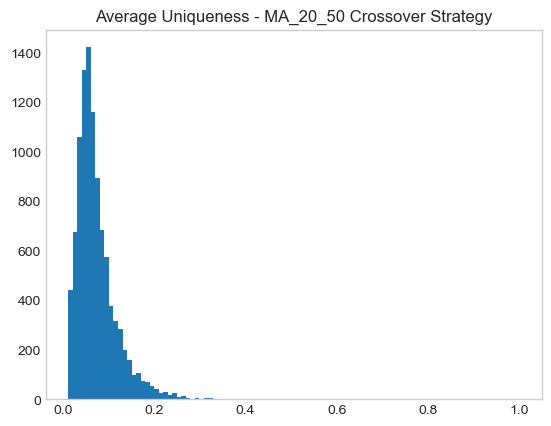

In [ ]:
cont_train["tW"].hist(bins=100, grid=False)
plt.title(f"Average Uniqueness - MA_{fast_window}_{slow_window} Crossover Strategy");

In [ ]:
cv_gen = PurgedKFold(n_splits, cont_train.t1, pct_embargo)
cv_scores_d = {k: {} for k in clfs.keys()}
print(rf.__class__.__name__, "Weighting Schemes")
all_clf_scores_df = pd.DataFrame(dtype=pd.StringDtype())
best_models = []

for scheme, sample_weights in weighting_schemes.items():
    best_score, best_model = None, None
    for param, clf in clfs.items():
        w = sample_weights.values
        cv_scores = ml_cross_val_score(
            clf, X_train, y_train, cv_gen, 
            sample_weight_train=w, 
            sample_weight_score=w,
            scoring="f1",
        )
        score = cv_scores.mean()
        cv_scores_d[param][scheme] = score
        best_score = max(best_score, score) if best_score is not None else score
        if score == best_score:
            best_model = param
        all_clf_scores_df.loc[param, scheme] = f"{cv_scores.mean():.6f} ± {cv_scores.std():.4f}"
    best_models.append(best_model)
    print(f"{scheme} {best_model} model achieved the best f1 score of {best_score:.6f}")

print()
pprint(all_clf_scores_df, sort_dicts=False)
best_model = max(best_models, key=best_models.count)
best_clf = clone(clfs[best_model])
print(f"\nSelected Best Classifier ({best_model}): {best_clf}")

RandomForestClassifier Weighting Schemes
unweighted balanced_subsample model achieved the best f1 score of 0.405778
uniqueness balanced_subsample model achieved the best f1 score of 0.326313
return combined model achieved the best f1 score of 0.674708

                           unweighted         uniqueness             return
standard            0.000000 ± 0.0000  0.000000 ± 0.0000  0.480684 ± 0.1373
balanced_subsample  0.405778 ± 0.0620  0.326313 ± 0.0933  0.674708 ± 0.0518
max_samples         0.000000 ± 0.0000  0.000000 ± 0.0000  0.291804 ± 0.1409
combined            0.358043 ± 0.0838  0.249652 ± 0.1109  0.674708 ± 0.0518

Selected Best Classifier (balanced_subsample): RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       min_weight_fraction_leaf=0.05, n_jobs=-1,
                       random_state=42)


In [ ]:
all_cv_scores_d = {}
all_cms = {}
best_score, best_model = None, None
all_cv_scores_df = pd.DataFrame(dtype=pd.StringDtype())

for scheme, sample_weights in weighting_schemes.items():
    w = sample_weights.values
    cv_scores, cv_scores_df, cms = analyze_cross_val_scores(
        best_clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    score = cv_scores['f1'].mean()
    all_cv_scores_d[scheme] = cv_scores
    all_cms[scheme] = cms
    best_score = max(best_score, score) if best_score is not None else score
    if score == best_score:
        best_model = scheme
    for idx, row in cv_scores_df.iterrows():
        all_cv_scores_df.loc[idx, scheme] = f"{row['mean']:.6f} ± {row['std']:.3f}"
pprint(all_cv_scores_df)
print(f"\n{best_model} model achieved the best f1 score of {best_score:.6f}\n")

                   unweighted       uniqueness           return
accuracy       0.5640 ± 0.081   0.6234 ± 0.070   0.5116 ± 0.063
pwa            0.5954 ± 0.103   0.7045 ± 0.070   0.5103 ± 0.065
neg_log_loss  -0.6810 ± 0.025  -0.6501 ± 0.024  -0.7781 ± 0.058
precision      0.3450 ± 0.036   0.3223 ± 0.046   0.5116 ± 0.063
recall         0.5335 ± 0.186   0.3749 ± 0.181   1.0000 ± 0.000
f1             0.4058 ± 0.062   0.3263 ± 0.093   0.6747 ± 0.052

return model achieved the best f1 score of 0.674708



In [ ]:
pprint(all_cms, sort_dicts=False)

{'unweighted': [{'fold': 1, 'TN': 393.0, 'FP': 328.0, 'FN': 110.0, 'TP': 185.0},
                {'fold': 2, 'TN': 483.0, 'FP': 248.0, 'FN': 158.0, 'TP': 127.0},
                {'fold': 3, 'TN': 450.0, 'FP': 279.0, 'FN': 156.0, 'TP': 131.0},
                {'fold': 4, 'TN': 578.0, 'FP': 161.0, 'FN': 187.0, 'TP': 90.0},
                {'fold': 5, 'TN': 139.0, 'FP': 482.0, 'FN': 80.0, 'TP': 315.0},
                {'fold': 6, 'TN': 336.0, 'FP': 419.0, 'FN': 91.0, 'TP': 170.0},
                {'fold': 7, 'TN': 518.0, 'FP': 229.0, 'FN': 158.0, 'TP': 111.0},
                {'fold': 8, 'TN': 596.0, 'FP': 127.0, 'FN': 205.0, 'TP': 88.0},
                {'fold': 9, 'TN': 480.0, 'FP': 267.0, 'FN': 150.0, 'TP': 119.0},
                {'fold': 10,
                 'TN': 129.0,
                 'FP': 554.0,
                 'FN': 41.0,
                 'TP': 292.0}],
 'uniqueness': [{'fold': 1, 'TN': 30.15, 'FP': 15.23, 'FN': 8.09, 'TP': 8.55},
                {'fold': 2, 'TN': 38.07, 'FP':

In [ ]:
winsound.Beep(1000, 1000)